In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [98]:
df=pd.read_csv('data/train.tsv', sep='\t')
df_test=pd.read_csv('data/test.tsv', sep='\t')
# df=df.head(1000)

In [99]:


def BOW1_tokenize(data):
    feature_set=set()
    for row in data:
        token_list=row.split()
        for token in token_list:
            feature_set.add(token)
    return feature_set

    
# Bag of Word 特征提取，基于单词的特征模型。
def BOW1_creat_feature(data,feature_set):
    feature_size=len(feature_set)
    feature_list=np.zeros((data.shape[0],feature_size)).astype('int16')
    feature_map=dict(zip(feature_set,range(feature_size)))
    for index in range(data.shape[0]):
        token_list=data[index].split()
        for token in token_list:
            if token in feature_set:
                feature_index=feature_map[token]
                feature_list[index,feature_index]+=1
    return feature_list


In [100]:


def NGram_tokenize(data,ngram=2):
    # ngram特征集合
    feature_set=set()
    for row in data:
        token_list=row.split()
        # 对每个词提取ngram特征
        for token in token_list:
            for i in range(len(token)-ngram):
                feature_set.add(token[i:i+ngram])
    return feature_set

    
def NGram_creat_feature(data,feature_set,ngram=2):

    # NGram 特征提取。
    
    feature_size=len(feature_set)
    feature_list=np.zeros((data.shape[0],feature_size)).astype('int16')
    feature_map=dict(zip(feature_set,range(feature_size)))
    for index in range(data.shape[0]):
        token_list=data[index].split()
        for token in token_list:
            for i in range(len(token)-ngram):
                gram=token[i:i+ngram]
                if gram in feature_set:
                    feature_index=feature_map[gram]
                    feature_list[index,feature_index]+=1
    return feature_list


In [101]:
def CreateFeature(ngram=2,analyzer='word'):
    if analyzer=='word':
        feature_set=BOW1_tokenize(data=df['Phrase'].to_numpy())
        X=BOW1_creat_feature(data=df['Phrase'].to_numpy(),feature_set=feature_set)
        test_X=BOW1_creat_feature(data=df_test['Phrase'].to_numpy(),feature_set=feature_set)
    if analyzer=='char':
        feature_set=NGram_tokenize(data=df['Phrase'].to_numpy(),ngram=ngram)
        X=NGram_creat_feature(data=df['Phrase'].to_numpy(),feature_set=feature_set,ngram=ngram)
        test_X=NGram_creat_feature(data=df_test['Phrase'].to_numpy(),feature_set=feature_set,ngram=ngram)
    return feature_set,X,test_X

In [102]:
def train_test_split(X,y,test_rate):
    X_size=X.shape[0]
    train_size=int((1-test_rate)*X_size)
    index = [i for i in range(X_size)] 
    # print(train_size)
    random.shuffle(index)
    train_X = X[index][0:train_size]
    train_y = y[index][0:train_size]
    val_X = X[index][train_size+1:-1]
    val_y = y[index][train_size+1:-1]
    # print(train_X.shape,val_X.shape,train_y.shape,val_y.shape)
    return train_X,val_X,train_y,val_y




In [103]:


# def train(batchsize=32,lr=1e0,epoch_number=100):
#     iter_number=train_X.shape[0]//batchsize
#     iter_remain=train_X.shape[0]%batchsize
#     weight=np.zeros((train_X.shape[1],class_number))
#     # 不同初始值的影响
#     # weight=np.random.normal(0,1,[train_X.shape[1],class_number])
#     loss_list=[]
#     for i in range(epoch_number):
#         loss=0
#         for j in tqdm(range(iter_number)):
#             train_data=train_X[j*batchsize:j*batchsize+batchsize]
#             train_label=train_y[j*batchsize:j*batchsize+batchsize]
#             weight_temp=np.zeros((train_X.shape[1],class_number))
#             for z in range(batchsize):
#                 y=train_label[z]               
#                 y_hat=np.exp(train_data[z].dot(weight))/np.sum(np.exp(train_data[z].dot(weight)))
#                 loss+= (-1/train_X.shape[0])*np.sum(np.multiply(y,np.log10(y_hat)))
#                 weight_temp+=(lr/batchsize)*np.outer(train_data[z],(y-y_hat))
#             weight+=weight_temp
#         print(loss)
#         loss_list.append(loss)
        
#     return loss_list,weight

# 矩阵乘法加速
def train_faster(train_X,train_y,val_X,val_y,batchsize=32,lr=1e0,epoch_number=100):
    iter_number=train_X.shape[0]//batchsize
    iter_remain=train_X.shape[0]%batchsize
    weight=np.zeros((train_X.shape[1],class_number))
    # 不同初始值的影响
    # weight=np.random.normal(0,1,[train_X.shape[1],class_number])
    train_loss_list=[]
    test_loss_list=[]
    for i in range(epoch_number):
        train_loss=0
        test_loss=0
        for j in tqdm(range(iter_number)):
            train_data=train_X[j*batchsize:j*batchsize+batchsize]
            y_train=train_y[j*batchsize:j*batchsize+batchsize]
            y=np.exp(train_data.dot(weight))   
            y_hat=np.divide(y.T,np.sum(y,axis=1)).T
            train_loss+= (-1/train_X.shape[0])*np.sum(np.multiply(y_train,np.log10(y_hat)))
            # 每个batch权重更新一次
            weight+=(lr/batchsize)*train_data.T.dot(y_train-y_hat)
       
        y=np.exp(val_X.dot(weight))   
        y_hat=np.divide(y.T,np.sum(y,axis=1)).T
        test_loss= (-1/val_X.shape[0])*np.sum(np.multiply(val_y,np.log10(y_hat)))
        # print('train_loss:',train_loss," test_loss:",test_loss)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
    
    return train_loss_list,test_loss_list,weight


In [104]:
def drawpic(train_loss_list=[],test_loss_list=[],epoch_number=10,path='1.jpg'):
    # make data
    x = [i for i in range(epoch_number)]
    # plot
    fig, ax = plt.subplots()
    ax.plot(x, train_loss_list, linewidth=2.0)
    ax.plot(x, test_loss_list, linewidth=2.0)
    plt.savefig(path)
    plt.show()
 

In [105]:
class_number=5
y=df['Sentiment'].to_numpy()
y_onehot=np.zeros((y.shape[0],class_number)).astype('int16')
for i in range(y.shape[0]):
    y_onehot[i,y[i]]+=1



parameter_list=[
    {'ngram':2,'analyzer':'word','batchsize':32,"lr":1e0,'epoch_number':20,'test_rate':0.2},
    {'ngram':2,'analyzer':'char','batchsize':32,"lr":1e0,'epoch_number':20,'test_rate':0.2},
    {'ngram':3,'analyzer':'char','batchsize':32,"lr":1e0,'epoch_number':20,'test_rate':0.2},
    {'ngram':2,'analyzer':'word','batchsize':8,"lr":1e0,'epoch_number':20,'test_rate':0.2},
    {'ngram':2,'analyzer':'word','batchsize':128,"lr":1e0,'epoch_number':20,'test_rate':0.2},
    {'ngram':2,'analyzer':'word','batchsize':32,"lr":1e1,'epoch_number':20,'test_rate':0.2},
    {'ngram':2,'analyzer':'word','batchsize':32,"lr":1e0,'epoch_number':10,'test_rate':0.2},

]

def flow(parameter_list):
    for parameter_dict in parameter_list:
        
        ngram=parameter_dict['ngram']
        analyzer=parameter_dict['analyzer']
        batchsize=parameter_dict['batchsize']
        lr=parameter_dict['lr']
        epoch_number=parameter_dict['epoch_number']
        test_rate=parameter_dict['test_rate']

        
        feature_set,X,test_X=CreateFeature(ngram=ngram,analyzer=analyzer)

        train_X,val_X,train_y,val_y=train_test_split(X,y_onehot,test_rate=test_rate)
        train_loss_list,test_loss_list,weight=train_faster(train_X=train_X,train_y=train_y,val_X=val_X,val_y=val_y,batchsize=batchsize,lr=lr,epoch_number=epoch_number)
        

        y_temp=np.exp(val_X.dot(weight))   
        y_temp=np.divide(y_temp.T,np.sum(y_temp,axis=1)).T
        y_predict=np.array([np.argmax(i) for i in y_temp])
        y_val=np.array([np.argmax(i) for i in val_y])

        acc=np.sum(y_predict.astype('int')==y_val.astype('int'))/y_val.shape[0]
        parameter_dict['acc']='%.4f' % acc
        print('acc:',acc)

        parameter_dict['best_train_loss']='%.4f' % np.min(train_loss_list) 
        parameter_dict['best_test_loss']='%.4f' % np.min(test_loss_list)
        
        print('train_loss:',parameter_dict['best_train_loss']," test_loss:",parameter_dict['best_test_loss'])
      
        path='pic/ngram_{}-analyzer_{}-lr_{}-batchsize_{}-epoch_number_{}-test_rate_{}.jpg'.format(str(ngram),str(analyzer),str(lr),str(batchsize),str(epoch_number),str(test_rate))
        parameter_dict['path']=path
        print(path)
        drawpic(train_loss_list=train_loss_list,test_loss_list=test_loss_list,epoch_number=epoch_number,path=path)
    return parameter_list
    



100%|██████████| 25/25 [00:00<00:00, 8266.92it/s]


acc: 0.494949494949495
train_loss: 0.3815  test_loss: 0.5423
pic/ngram_2-analyzer_word-lr_1.0-batchsize_32-epoch_number_20-test_rate_0.2.jpg


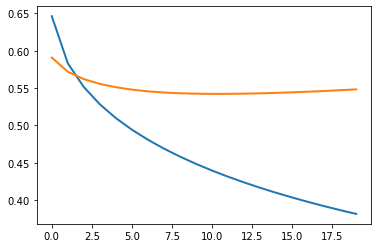

100%|██████████| 25/25 [00:00<00:00, 12523.30it/s]


acc: 0.494949494949495
train_loss: 0.4033  test_loss: 0.5376
pic/ngram_2-analyzer_char-lr_1.0-batchsize_32-epoch_number_20-test_rate_0.2.jpg


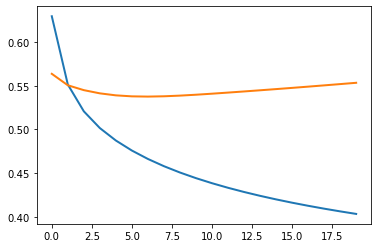

100%|██████████| 25/25 [00:00<00:00, 5826.72it/s]


acc: 0.5303030303030303
train_loss: 0.3559  test_loss: 0.5807
pic/ngram_3-analyzer_char-lr_1.0-batchsize_32-epoch_number_20-test_rate_0.2.jpg


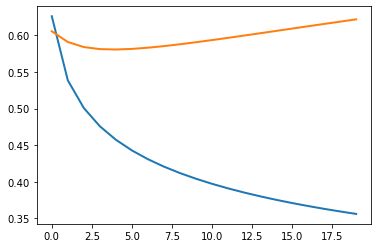

100%|██████████| 100/100 [00:00<00:00, 20055.97it/s]


acc: 0.5707070707070707
train_loss: 0.3200  test_loss: 0.5200
pic/ngram_2-analyzer_word-lr_1.0-batchsize_8-epoch_number_20-test_rate_0.2.jpg


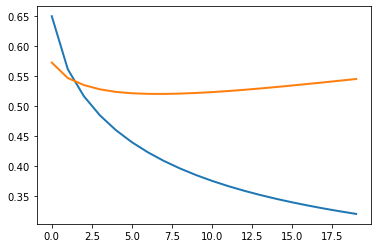

100%|██████████| 6/6 [00:00<00:00, 6013.34it/s]


acc: 0.5
train_loss: 0.4699  test_loss: 0.5582
pic/ngram_2-analyzer_word-lr_1.0-batchsize_128-epoch_number_20-test_rate_0.2.jpg


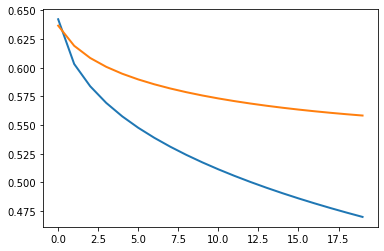

100%|██████████| 25/25 [00:00<00:00, 12533.78it/s]


acc: 0.494949494949495
train_loss: 0.2863  test_loss: 0.6994
pic/ngram_2-analyzer_word-lr_10.0-batchsize_32-epoch_number_20-test_rate_0.2.jpg


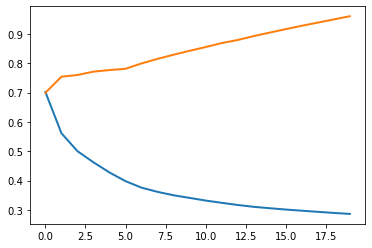

100%|██████████| 25/25 [00:00<00:00, 8363.18it/s]

acc: 0.5707070707070707
train_loss: 0.4530  test_loss: 0.5318
pic/ngram_2-analyzer_word-lr_1.0-batchsize_32-epoch_number_10-test_rate_0.2.jpg


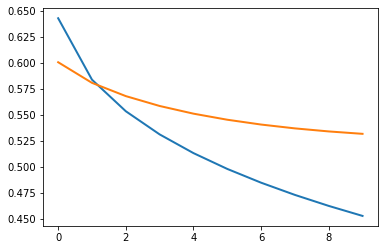

In [106]:
parameter_list=flow(parameter_list)

In [107]:
for i in parameter_list:
    print(i)

{'ngram': 2, 'analyzer': 'word', 'batchsize': 32, 'lr': 1.0, 'epoch_number': 20, 'test_rate': 0.2, 'acc': '0.4949', 'best_train_loss': '0.3815', 'best_test_loss': '0.5423', 'path': 'pic/ngram_2-analyzer_word-lr_1.0-batchsize_32-epoch_number_20-test_rate_0.2.jpg'}
{'ngram': 2, 'analyzer': 'char', 'batchsize': 32, 'lr': 1.0, 'epoch_number': 20, 'test_rate': 0.2, 'acc': '0.4949', 'best_train_loss': '0.4033', 'best_test_loss': '0.5376', 'path': 'pic/ngram_2-analyzer_char-lr_1.0-batchsize_32-epoch_number_20-test_rate_0.2.jpg'}
{'ngram': 3, 'analyzer': 'char', 'batchsize': 32, 'lr': 1.0, 'epoch_number': 20, 'test_rate': 0.2, 'acc': '0.5303', 'best_train_loss': '0.3559', 'best_test_loss': '0.5807', 'path': 'pic/ngram_3-analyzer_char-lr_1.0-batchsize_32-epoch_number_20-test_rate_0.2.jpg'}
{'ngram': 2, 'analyzer': 'word', 'batchsize': 8, 'lr': 1.0, 'epoch_number': 20, 'test_rate': 0.2, 'acc': '0.5707', 'best_train_loss': '0.3200', 'best_test_loss': '0.5200', 'path': 'pic/ngram_2-analyzer_word-l